# Libary import

In [3]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-bcyrc294
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-bcyrc294
  Stored in directory: /tmp/pip-ephem-wheel-cache-x7d1x1qh/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [4]:
from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace

In [7]:
import os
import cv2
import h5py
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from glob import glob
from random import choice, sample
from tqdm import tqdm
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Input, Dense, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, Reshape, Flatten
from keras.models import Model
from keras.optimizers import Adam, Adagrad, RMSprop
from keras.preprocessing import image
from keras import regularizers

# Function define

In [6]:
def read_img(path):  # read_img function with path parameter
    img = image.load_img(path, target_size=(224, 224))  # loading the image as 224*224 size
    img = np.array(img).astype(np.float)  # converting the image into a array of floats
    return preprocess_input(img, version=2)  # normalize each pixel value

def gen(list_tuples, person_to_images_map, batch_size=16):
    ppl = list(person_to_images_map.keys())
    while True:
        batch_tuples = sample(list_tuples, batch_size // 2)
        labels = [1] * len(batch_tuples)
        while len(batch_tuples) < batch_size:
            p1 = choice(ppl)
            p2 = choice(ppl)

            if p1 != p2 and (p1, p2) not in list_tuples and (p2, p1) not in list_tuples:
                batch_tuples.append((p1, p2))
                labels.append(0)

        for x in batch_tuples:
            if not len(person_to_images_map[x[0]]):
                print(x[0])

        X1 = [choice(person_to_images_map[x[0]]) for x in batch_tuples]
        X1 = np.array([read_img(x) for x in X1])

        X2 = [choice(person_to_images_map[x[1]]) for x in batch_tuples]
        X2 = np.array([read_img(x) for x in X2])

        yield [X1, X2], labels


def baseline_model():
    input_1 = Input(shape=(224, 224, 3))
    input_2 = Input(shape=(224, 224, 3))

    base_model = VGGFace(model='resnet50', include_top=False)  

    for x in base_model.layers[:-3]:
        x.trainable = True

    x1 = base_model(input_1)
    x2 = base_model(input_2)

    x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])  # next layer
    x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])

    x3 = Subtract()([x1, x2])  # next layer
    x3 = Multiply()([x3, x3])  # next layer

    x1_ = Multiply()([x1, x1])
    x2_ = Multiply()([x2, x2])
    x4  = Subtract()([x1_, x2_])
    
    x5 = Multiply()([x1, x2])
    
    x = Concatenate(axis=-1)([x4, x3, x5])

    x = Dense(100, activation="relu")(x)
    x = Dropout(0.01)(x)
    out = Dense(1, activation="sigmoid")(x)

    model = Model([input_1, input_2], out)

    model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=Adam(0.00001))

    model.summary()

    return model

In [7]:
import matplotlib.pyplot as plt
def plot_accuracy(y):
    if(y == True):
        plt.plot(curr_model_hist.history['acc'])
        plt.plot(curr_model_hist.history['val_acc'])
        plt.legend(['train', 'validation'], loc='lower right')
        plt.title('accuracy plot - train vs validation')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.show()
    else:
        pass
    return

def plot_loss(y):
    if(y == True):
        plt.plot(curr_model_hist.history['loss'])
        plt.plot(curr_model_hist.history['val_loss'])
        plt.legend(['training loss', 'validation loss'], loc = 'upper right')
        plt.title('loss plot - training vs vaidation')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
    else:
        pass
    return

# Val_loss 기준 Early Stopping

94699520/94694792 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 2048)

/opt/conda/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


 - 85s - loss: 3.6768 - acc: 0.6000 - val_loss: 3.9592 - val_acc: 0.6250

Epoch 00001: val_acc improved from -inf to 0.62500, saving model to vgg_face_val_loss_00.h5
Epoch 2/120
 - 57s - loss: 2.5467 - acc: 0.6631 - val_loss: 2.6565 - val_acc: 0.7000

Epoch 00002: val_acc improved from 0.62500 to 0.70000, saving model to vgg_face_val_loss_00.h5
Epoch 3/120
 - 59s - loss: 1.5698 - acc: 0.6891 - val_loss: 1.6866 - val_acc: 0.6562

Epoch 00003: val_acc did not improve from 0.70000
Epoch 4/120
 - 58s - loss: 0.9411 - acc: 0.7028 - val_loss: 1.3909 - val_acc: 0.6937

Epoch 00004: val_acc did not improve from 0.70000
Epoch 5/120
 - 57s - loss: 0.6634 - acc: 0.7331 - val_loss: 0.7212 - val_acc: 0.7125

Epoch 00005: val_acc improved from 0.70000 to 0.71250, saving model to vgg_face_val_loss_00.h5
Epoch 6/120
 - 57s - loss: 0.5570 - acc: 0.7509 - val_loss: 0.7226 - val_acc: 0.6500

Epoch 00006: val_acc did not improve from 0.71250
Epoch 7/120
 - 57s - loss: 0.4919 - acc: 0.7756 - val_loss: 0.86

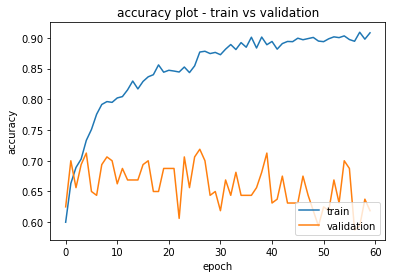

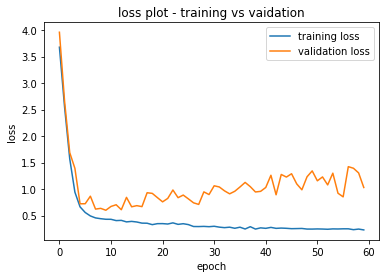

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_3 (GlobalM (None, 2048)         0           vggface_resnet50[1][0]           
__________

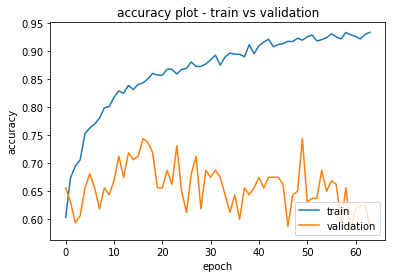

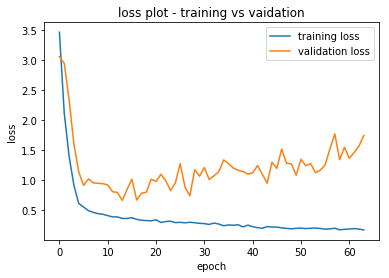

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_5 (GlobalM (None, 2048)         0           vggface_resnet50[1][0]           
__________

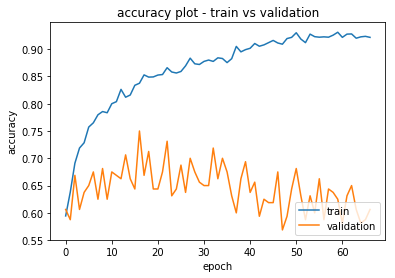

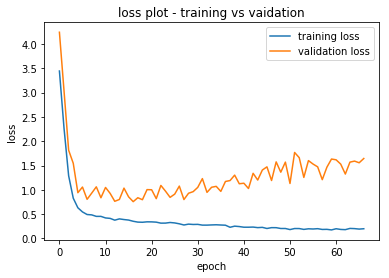

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_10[0][0]                   
                                                                 input_11[0][0]                   
__________________________________________________________________________________________________
global_max_pooling2d_7 (GlobalM (None, 2048)         0           vggface_resnet50[1][0]           
__________

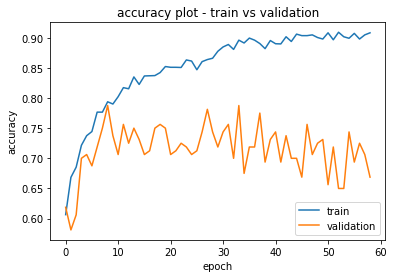

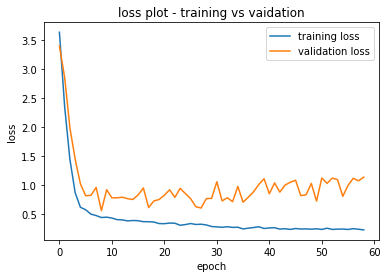

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
global_max_pooling2d_9 (GlobalM (None, 2048)         0           vggface_resnet50[1][0]           
__________

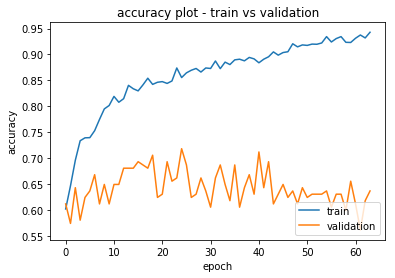

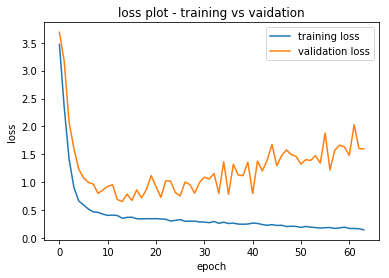

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_16[0][0]                   
                                                                 input_17[0][0]                   
__________________________________________________________________________________________________
global_max_pooling2d_11 (Global (None, 2048)         0           vggface_resnet50[1][0]           
__________

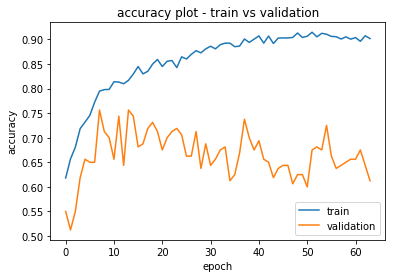

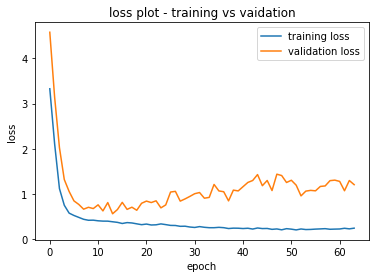

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_19[0][0]                   
                                                                 input_20[0][0]                   
__________________________________________________________________________________________________
global_max_pooling2d_13 (Global (None, 2048)         0           vggface_resnet50[1][0]           
__________

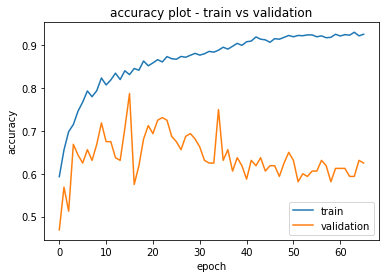

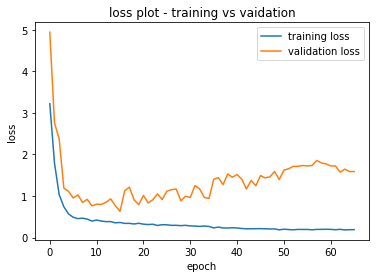

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_22[0][0]                   
                                                                 input_23[0][0]                   
__________________________________________________________________________________________________
global_max_pooling2d_15 (Global (None, 2048)         0           vggface_resnet50[1][0]           
__________

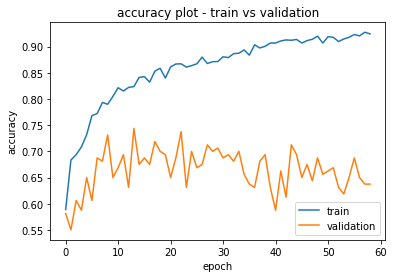

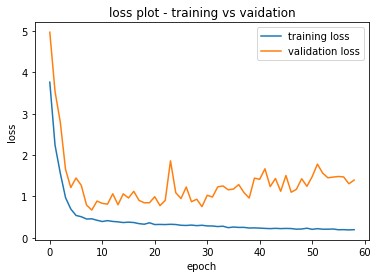

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_25[0][0]                   
                                                                 input_26[0][0]                   
__________________________________________________________________________________________________
global_max_pooling2d_17 (Global (None, 2048)         0           vggface_resnet50[1][0]           
__________

In [ ]:
for i in ['00','01','02','03','04','05','06','07']:
    train_file_path = "../input/train_relationships.csv"
    train_folders_path = "../input/train/"
    val_families = "F" + i

    #all_images = glob(train_folders_path + "*/*/*.jpg")
    all_images = glob('/kaggle/input/rfiwsmile/recognizing-faces-in-the-wild/train/' + "*/*/*.jpg")

    training_data_images = [x for x in all_images]  # list all the images
    validation_set_images = [x for x in all_images if val_families in x] # list images that belong to val_families
    # print(validation_set_images)
    train_person_to_images_map = defaultdict(list)

    ppl = [x.split("/")[-3] + "/" + x.split("/")[-2] for x in all_images]
    # print(ppl)
    # print(len(ppl))  # 12379 pics in total

    for x in training_data_images:
        train_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)  # total number of ppl in the data set
    
    # print(train_person_to_images_map)  # segregates pics of each person in each family of train images
    # print(len(train_person_to_images_map))  # 2316 ppl in total

    val_person_to_images_map = defaultdict(list)

    for x in validation_set_images:
        val_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

    # print(val_person_to_images_map)  # segregates pics of each person in each family of val images
    # print(len(val_person_to_images_map))  # 263 ppl in total
    
    relationships = pd.read_csv('/kaggle/input/rfiwsmile/recognizing-faces-in-the-wild/train_relationships.csv')
    # print(relationships)
    relationships = list(zip(relationships.p1.values, relationships.p2.values))
    # print(relationships)
    # print(len(relationships))  # 3598 realtions or rows in the csv file
    relationships = [x for x in relationships if x[0] in ppl and x[1] in ppl]  # to eliminate the false relations
    # relationships = [x for x in relationships if x[0] in ppl and x[1] not in ppl]
    # print(relationships)
    # print(len(relationships))  # 3362 true relations

    train_relationships = [x for x in relationships if val_families not in x[0]]  # all the relations without the val_families
    # print(train_relationships)
    val_relationships = [x for x in relationships if val_families in x[0]]  # relations only with the val_families
    # print(val_relationships)
    
    
    
    
    file_path = "vgg_face_val_loss_" + i + ".h5"

    #verbose is a parameter which deicdes how much information is to be displayed on the terminal every epoch 
    checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    # A function to save the model after monitering a value ( val_acc ), once when it has reached 
    #the best value (save_best_only) when the value is its max value ( mode = 'max')

    reduce_on_plateau = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.1, patience=20, verbose=1)
    # A function to reduce the learning rate by  a factor (factor) based on monitering a value (val_acc) if it has no improvemnt 
    #from its best score (mode = 'max') for a few epochs (patience)

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    # A fucntion to stop the training after a few rounds (patience) if there is no improvement on the value being monitered
    #( loss ) based on its best score depending if it is to be maximised or minimised (mode)

    callbacks_list = [checkpoint, reduce_on_plateau, es]

    curr_model = baseline_model()  # initializing model with the given layes
    #curr_model.load_weights(file_path)
    curr_model_hist = curr_model.fit_generator(gen(train_relationships, train_person_to_images_map, batch_size=16), use_multiprocessing=True,
                        validation_data=gen(val_relationships, val_person_to_images_map, batch_size=16), epochs=120, verbose=2,
                        workers=4, callbacks=callbacks_list, steps_per_epoch=200, validation_steps=10)
    
    plot_accuracy(True)
    plot_loss(True)

94699520/94694792 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 2048)

/opt/conda/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


 - 85s - loss: 3.5491 - acc: 0.6162 - val_loss: 5.2848 - val_acc: 0.5188

Epoch 00001: val_acc improved from -inf to 0.51875, saving model to vgg_face_val_loss_08.h5
Epoch 2/120
 - 58s - loss: 2.4119 - acc: 0.6681 - val_loss: 2.6683 - val_acc: 0.6312

Epoch 00002: val_acc improved from 0.51875 to 0.63125, saving model to vgg_face_val_loss_08.h5
Epoch 3/120
 - 58s - loss: 1.5139 - acc: 0.6900 - val_loss: 2.1022 - val_acc: 0.6000

Epoch 00003: val_acc did not improve from 0.63125
Epoch 4/120
 - 58s - loss: 0.9126 - acc: 0.7131 - val_loss: 1.5582 - val_acc: 0.6375

Epoch 00004: val_acc improved from 0.63125 to 0.63750, saving model to vgg_face_val_loss_08.h5
Epoch 5/120
 - 58s - loss: 0.6973 - acc: 0.7288 - val_loss: 0.8880 - val_acc: 0.7000

Epoch 00005: val_acc improved from 0.63750 to 0.70000, saving model to vgg_face_val_loss_08.h5
Epoch 6/120
 - 56s - loss: 0.5700 - acc: 0.7459 - val_loss: 0.9552 - val_acc: 0.6750

Epoch 00006: val_acc did not improve from 0.70000
Epoch 7/120
 - 58s 

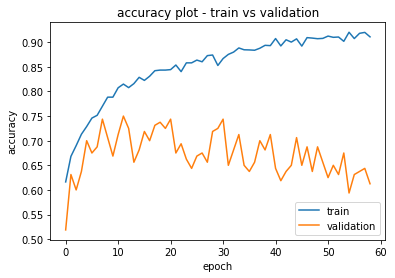

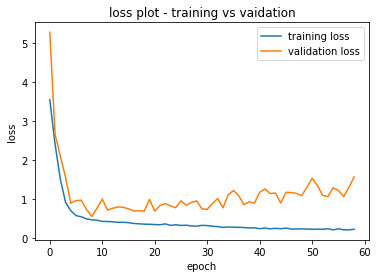

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_3 (GlobalM (None, 2048)         0           vggface_resnet50[1][0]           
__________

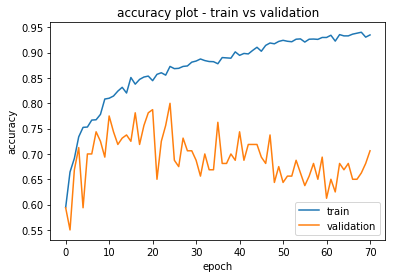

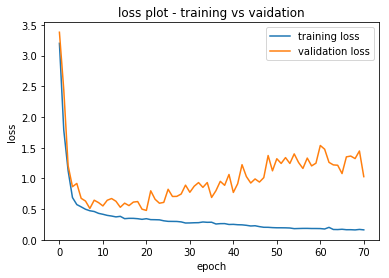

In [8]:
for i in ['08','09']:
    train_file_path = "../input/train_relationships.csv"
    train_folders_path = "../input/train/"
    val_families = "F" + i

    #all_images = glob(train_folders_path + "*/*/*.jpg")
    all_images = glob('/kaggle/input/rfiwsmile/recognizing-faces-in-the-wild/train/' + "*/*/*.jpg")

    training_data_images = [x for x in all_images]  # list all the images
    validation_set_images = [x for x in all_images if val_families in x] # list images that belong to val_families
    # print(validation_set_images)
    train_person_to_images_map = defaultdict(list)

    ppl = [x.split("/")[-3] + "/" + x.split("/")[-2] for x in all_images]
    # print(ppl)
    # print(len(ppl))  # 12379 pics in total

    for x in training_data_images:
        train_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)  # total number of ppl in the data set
    
    # print(train_person_to_images_map)  # segregates pics of each person in each family of train images
    # print(len(train_person_to_images_map))  # 2316 ppl in total

    val_person_to_images_map = defaultdict(list)

    for x in validation_set_images:
        val_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

    # print(val_person_to_images_map)  # segregates pics of each person in each family of val images
    # print(len(val_person_to_images_map))  # 263 ppl in total
    
    relationships = pd.read_csv('/kaggle/input/rfiwsmile/recognizing-faces-in-the-wild/train_relationships.csv')
    # print(relationships)
    relationships = list(zip(relationships.p1.values, relationships.p2.values))
    # print(relationships)
    # print(len(relationships))  # 3598 realtions or rows in the csv file
    relationships = [x for x in relationships if x[0] in ppl and x[1] in ppl]  # to eliminate the false relations
    # relationships = [x for x in relationships if x[0] in ppl and x[1] not in ppl]
    # print(relationships)
    # print(len(relationships))  # 3362 true relations

    train_relationships = [x for x in relationships if val_families not in x[0]]  # all the relations without the val_families
    # print(train_relationships)
    val_relationships = [x for x in relationships if val_families in x[0]]  # relations only with the val_families
    # print(val_relationships)
    
    
    
    
    file_path = "vgg_face_val_loss_" + i + ".h5"

    #verbose is a parameter which deicdes how much information is to be displayed on the terminal every epoch 
    checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    # A function to save the model after monitering a value ( val_acc ), once when it has reached 
    #the best value (save_best_only) when the value is its max value ( mode = 'max')

    reduce_on_plateau = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.1, patience=20, verbose=1)
    # A function to reduce the learning rate by  a factor (factor) based on monitering a value (val_acc) if it has no improvemnt 
    #from its best score (mode = 'max') for a few epochs (patience)

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    # A fucntion to stop the training after a few rounds (patience) if there is no improvement on the value being monitered
    #( loss ) based on its best score depending if it is to be maximised or minimised (mode)

    callbacks_list = [checkpoint, reduce_on_plateau, es]

    curr_model = baseline_model()  # initializing model with the given layes
    #curr_model.load_weights(file_path)
    curr_model_hist = curr_model.fit_generator(gen(train_relationships, train_person_to_images_map, batch_size=16), use_multiprocessing=True,
                        validation_data=gen(val_relationships, val_person_to_images_map, batch_size=16), epochs=120, verbose=2,
                        workers=4, callbacks=callbacks_list, steps_per_epoch=200, validation_steps=10)
    
    plot_accuracy(True)
    plot_loss(True)

## Val_acc 기준 Early Stopping

94699520/94694792 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 2048)

/opt/conda/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


 - 84s - loss: 3.8262 - acc: 0.5613 - val_loss: 3.7257 - val_acc: 0.6062

Epoch 00001: val_acc improved from -inf to 0.60625, saving model to vgg_face_val_acc_00.h5
Epoch 2/120
 - 57s - loss: 2.4099 - acc: 0.6438 - val_loss: 3.4536 - val_acc: 0.5625

Epoch 00002: val_acc did not improve from 0.60625
Epoch 3/120
 - 57s - loss: 1.4260 - acc: 0.6875 - val_loss: 1.6588 - val_acc: 0.6813

Epoch 00003: val_acc improved from 0.60625 to 0.68125, saving model to vgg_face_val_acc_00.h5
Epoch 4/120
 - 57s - loss: 0.8933 - acc: 0.7188 - val_loss: 1.3904 - val_acc: 0.6312

Epoch 00004: val_acc did not improve from 0.68125
Epoch 5/120
 - 60s - loss: 0.6785 - acc: 0.7288 - val_loss: 1.1089 - val_acc: 0.6188

Epoch 00005: val_acc did not improve from 0.68125
Epoch 6/120
 - 58s - loss: 0.5528 - acc: 0.7534 - val_loss: 0.9703 - val_acc: 0.6500

Epoch 00006: val_acc did not improve from 0.68125
Epoch 7/120
 - 58s - loss: 0.4839 - acc: 0.7816 - val_loss: 0.9999 - val_acc: 0.6375

Epoch 00007: val_acc did 

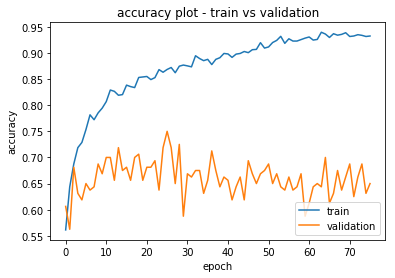

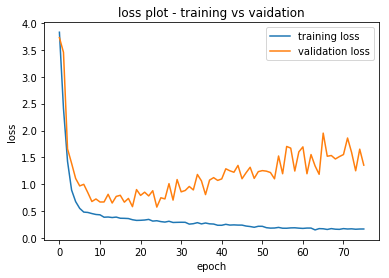

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_3 (GlobalM (None, 2048)         0           vggface_resnet50[1][0]           
__________

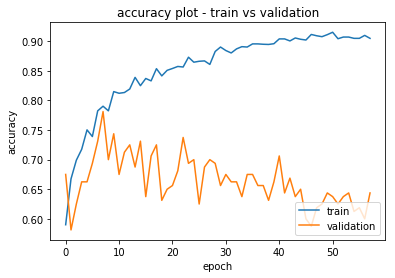

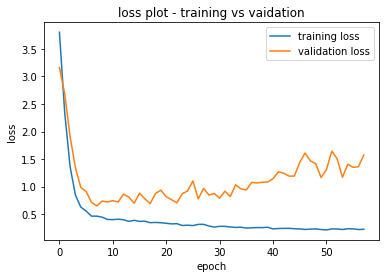

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_5 (GlobalM (None, 2048)         0           vggface_resnet50[1][0]           
__________

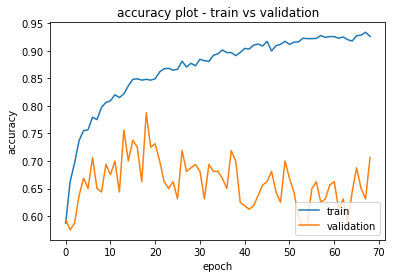

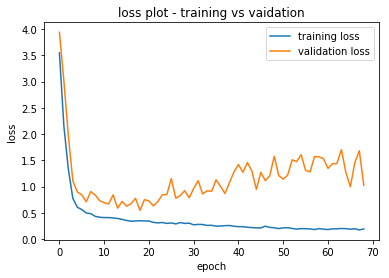

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_10[0][0]                   
                                                                 input_11[0][0]                   
__________________________________________________________________________________________________
global_max_pooling2d_7 (GlobalM (None, 2048)         0           vggface_resnet50[1][0]           
__________

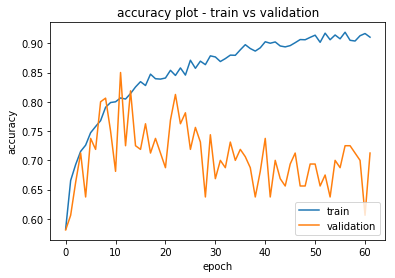

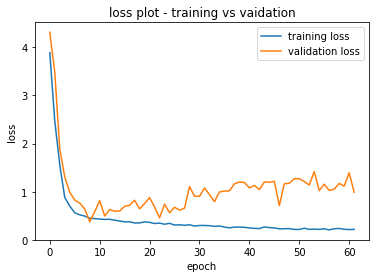

Epoch 1/120
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
global_max_pooling2d_9 (GlobalM (None, 2048)         0           vggface_resnet50[1][0]          

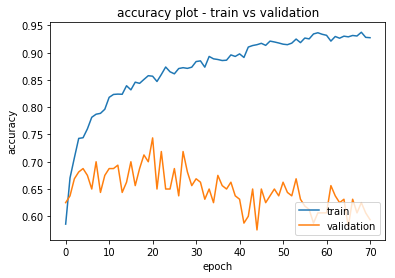

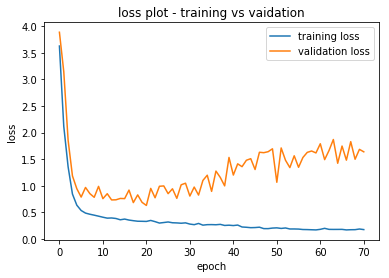

In [7]:
for i in ['00','01','02','03','04']: # ,'05','06','07','08','09'
    train_file_path = "../input/train_relationships.csv"
    train_folders_path = "../input/train/"
    val_families = "F" + i

    #all_images = glob(train_folders_path + "*/*/*.jpg")
    all_images = glob('/kaggle/input/rfiwsmile/recognizing-faces-in-the-wild/train/' + "*/*/*.jpg")

    training_data_images = [x for x in all_images]  # list all the images
    validation_set_images = [x for x in all_images if val_families in x] # list images that belong to val_families
    # print(validation_set_images)
    train_person_to_images_map = defaultdict(list)

    ppl = [x.split("/")[-3] + "/" + x.split("/")[-2] for x in all_images]
    # print(ppl)
    # print(len(ppl))  # 12379 pics in total

    for x in training_data_images:
        train_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)  # total number of ppl in the data set
    
    # print(train_person_to_images_map)  # segregates pics of each person in each family of train images
    # print(len(train_person_to_images_map))  # 2316 ppl in total

    val_person_to_images_map = defaultdict(list)

    for x in validation_set_images:
        val_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

    # print(val_person_to_images_map)  # segregates pics of each person in each family of val images
    # print(len(val_person_to_images_map))  # 263 ppl in total
    
    relationships = pd.read_csv('/kaggle/input/rfiwsmile/recognizing-faces-in-the-wild/train_relationships.csv')
    # print(relationships)
    relationships = list(zip(relationships.p1.values, relationships.p2.values))
    # print(relationships)
    # print(len(relationships))  # 3598 realtions or rows in the csv file
    relationships = [x for x in relationships if x[0] in ppl and x[1] in ppl]  # to eliminate the false relations
    # relationships = [x for x in relationships if x[0] in ppl and x[1] not in ppl]
    # print(relationships)
    # print(len(relationships))  # 3362 true relations

    train_relationships = [x for x in relationships if val_families not in x[0]]  # all the relations without the val_families
    # print(train_relationships)
    val_relationships = [x for x in relationships if val_families in x[0]]  # relations only with the val_families
    # print(val_relationships)
    
    
    
    
    file_path = "vgg_face_val_acc_" + i + ".h5"

    #verbose is a parameter which deicdes how much information is to be displayed on the terminal every epoch 
    checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    # A function to save the model after monitering a value ( val_acc ), once when it has reached 
    #the best value (save_best_only) when the value is its max value ( mode = 'max')

    reduce_on_plateau = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.1, patience=20, verbose=1)
    # A function to reduce the learning rate by  a factor (factor) based on monitering a value (val_acc) if it has no improvemnt 
    #from its best score (mode = 'max') for a few epochs (patience)

    es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=50)
    # A fucntion to stop the training after a few rounds (patience) if there is no improvement on the value being monitered
    #( loss ) based on its best score depending if it is to be maximised or minimised (mode)

    callbacks_list = [checkpoint, reduce_on_plateau, es]

    curr_model = baseline_model()  # initializing model with the given layes
    #curr_model.load_weights(file_path)
    curr_model_hist = curr_model.fit_generator(gen(train_relationships, train_person_to_images_map, batch_size=16), use_multiprocessing=True,
                        validation_data=gen(val_relationships, val_person_to_images_map, batch_size=16), epochs=120, verbose=2,
                        workers=4, callbacks=callbacks_list, steps_per_epoch=200, validation_steps=10)
    
    plot_accuracy(True)
    plot_loss(True)

94699520/94694792 [==============================] - 2s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 2048)

/opt/conda/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


 - 83s - loss: 3.6695 - acc: 0.5913 - val_loss: 5.1046 - val_acc: 0.5188

Epoch 00001: val_acc improved from -inf to 0.51875, saving model to vgg_face_val_acc_05.h5
Epoch 2/120
 - 56s - loss: 2.3334 - acc: 0.6606 - val_loss: 3.6792 - val_acc: 0.5500

Epoch 00002: val_acc improved from 0.51875 to 0.55000, saving model to vgg_face_val_acc_05.h5
Epoch 3/120
 - 57s - loss: 1.3914 - acc: 0.7044 - val_loss: 1.9201 - val_acc: 0.6562

Epoch 00003: val_acc improved from 0.55000 to 0.65625, saving model to vgg_face_val_acc_05.h5
Epoch 4/120
 - 56s - loss: 0.9401 - acc: 0.7113 - val_loss: 1.7035 - val_acc: 0.5875

Epoch 00004: val_acc did not improve from 0.65625
Epoch 5/120
 - 57s - loss: 0.6491 - acc: 0.7428 - val_loss: 1.2215 - val_acc: 0.6250

Epoch 00005: val_acc did not improve from 0.65625
Epoch 6/120
 - 57s - loss: 0.5728 - acc: 0.7625 - val_loss: 1.1282 - val_acc: 0.6813

Epoch 00006: val_acc improved from 0.65625 to 0.68125, saving model to vgg_face_val_acc_05.h5
Epoch 7/120
 - 56s - lo

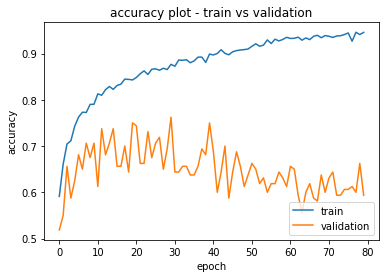

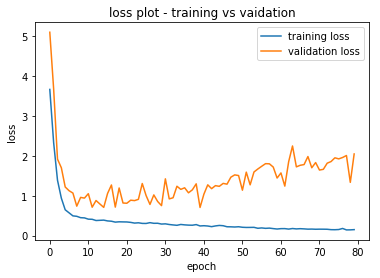

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_3 (GlobalM (None, 2048)         0           vggface_resnet50[1][0]           
__________

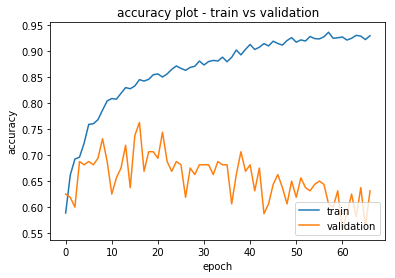

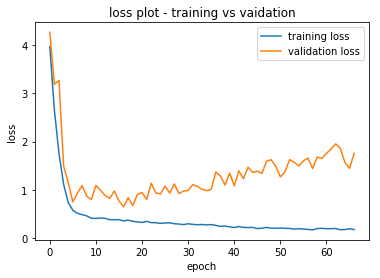

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_5 (GlobalM (None, 2048)         0           vggface_resnet50[1][0]           
__________

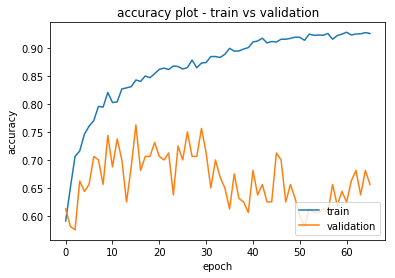

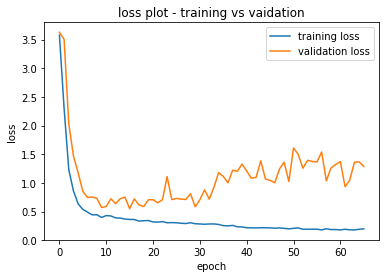

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_10[0][0]                   
                                                                 input_11[0][0]                   
__________________________________________________________________________________________________
global_max_pooling2d_7 (GlobalM (None, 2048)         0           vggface_resnet50[1][0]           
__________

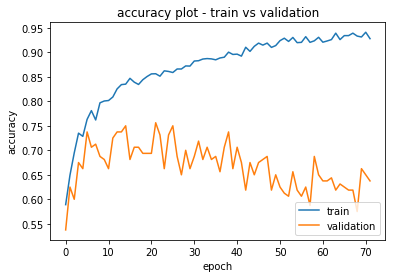

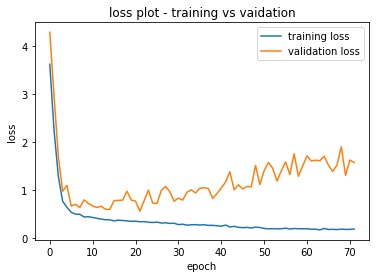

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
global_max_pooling2d_9 (GlobalM (None, 2048)         0           vggface_resnet50[1][0]           
__________

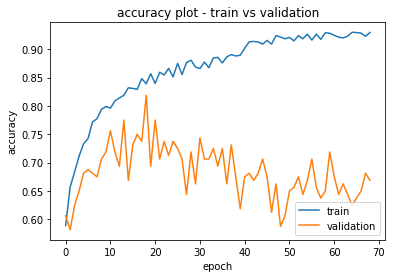

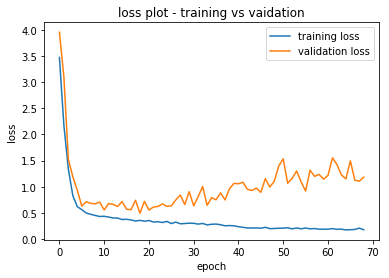

In [8]:
for i in ['05','06','07','08','09']:
    train_file_path = "../input/train_relationships.csv"
    train_folders_path = "../input/train/"
    val_families = "F" + i

    #all_images = glob(train_folders_path + "*/*/*.jpg")
    all_images = glob('/kaggle/input/rfiwsmile/recognizing-faces-in-the-wild/train/' + "*/*/*.jpg")

    training_data_images = [x for x in all_images]  # list all the images
    validation_set_images = [x for x in all_images if val_families in x] # list images that belong to val_families
    # print(validation_set_images)
    train_person_to_images_map = defaultdict(list)
    
    ppl = [x.split("/")[-3] + "/" + x.split("/")[-2] for x in all_images]
    # print(ppl)
    # print(len(ppl))  # 12379 pics in total

    for x in training_data_images:
        train_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)  # total number of ppl in the data set
    
    # print(train_person_to_images_map)  # segregates pics of each person in each family of train images
    # print(len(train_person_to_images_map))  # 2316 ppl in total

    val_person_to_images_map = defaultdict(list)

    for x in validation_set_images:
        val_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

    # print(val_person_to_images_map)  # segregates pics of each person in each family of val images
    # print(len(val_person_to_images_map))  # 263 ppl in total
    
    relationships = pd.read_csv('/kaggle/input/rfiwsmile/recognizing-faces-in-the-wild/train_relationships.csv')
    # print(relationships)
    relationships = list(zip(relationships.p1.values, relationships.p2.values))
    # print(relationships)
    # print(len(relationships))  # 3598 realtions or rows in the csv file
    relationships = [x for x in relationships if x[0] in ppl and x[1] in ppl]  # to eliminate the false relations
    # relationships = [x for x in relationships if x[0] in ppl and x[1] not in ppl]
    # print(relationships)
    # print(len(relationships))  # 3362 true relations

    train_relationships = [x for x in relationships if val_families not in x[0]]  # all the relations without the val_families
    # print(train_relationships)
    val_relationships = [x for x in relationships if val_families in x[0]]  # relations only with the val_families
    # print(val_relationships)
    
    
    
    
    file_path = "vgg_face_val_acc_" + i + ".h5"

    #verbose is a parameter which deicdes how much information is to be displayed on the terminal every epoch 
    checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    # A function to save the model after monitering a value ( val_acc ), once when it has reached 
    #the best value (save_best_only) when the value is its max value ( mode = 'max')

    reduce_on_plateau = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.1, patience=20, verbose=1)
    # A function to reduce the learning rate by  a factor (factor) based on monitering a value (val_acc) if it has no improvemnt 
    #from its best score (mode = 'max') for a few epochs (patience)

    es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=50)
    # A fucntion to stop the training after a few rounds (patience) if there is no improvement on the value being monitered
    #( loss ) based on its best score depending if it is to be maximised or minimised (mode)

    callbacks_list = [checkpoint, reduce_on_plateau, es]

    curr_model = baseline_model()  # initializing model with the given layes
    #curr_model.load_weights(file_path)
    curr_model_hist = curr_model.fit_generator(gen(train_relationships, train_person_to_images_map, batch_size=16), use_multiprocessing=True,
                        validation_data=gen(val_relationships, val_person_to_images_map, batch_size=16), epochs=120, verbose=2,
                        workers=4, callbacks=callbacks_list, steps_per_epoch=200, validation_steps=10)
    
    plot_accuracy(True)
    plot_loss(True)

# Make submission

## Average Ensemling of 20 models

val_loss 기준 10 fold CV한 모델 10개 + val_acc 기준 10 fold CV한 모델 10개 = 총 20개 모델의 prediction을 앙상블하여 제출파일 생성
- Score : 0.909

In [11]:
test_path = "/kaggle/input/rfiwsmile/recognizing-faces-in-the-wild/test/"

def chunker(seq, size=32):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

submission = pd.read_csv('/kaggle/input/rfiwsmile/recognizing-faces-in-the-wild/sample_submission.csv')

predictions = []

for batch in tqdm(chunker(submission.img_pair.values)):
    X1 = [x.split("-")[0] for x in batch]
    X1 = np.array([read_img(test_path + x) for x in X1])

    X2 = [x.split("-")[1] for x in batch]
    X2 = np.array([read_img(test_path + x) for x in X2])
    
    prediction = 0 
    for i in ['00','01','02','03','04','05','06','07','08','09']:
        curr_model.load_weights('/kaggle/input/vggface-val/vgg_face_val_loss_' + i + '.h5')#'../input/valaccall/Val_acc_f'+ i +'.h5')
        prediction = prediction + curr_model.predict([X1, X2])
    for i in ['00','01','02','03','04','05','06','07','08','09']:
        curr_model.load_weights('/kaggle/input/vggface-val/vgg_face_val_acc_' + i + '.h5')#'../input/vjmodels/F'+ i +'_val_loss.h5')
        prediction = prediction + curr_model.predict([X1, X2])
    prediction = prediction/20
    pred = prediction.ravel().tolist()
    predictions += pred

submission['is_related'] = predictions

submission.to_csv("sub_vggface.csv", index=False)

166it [1:00:01, 21.49s/it]
